In [2]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D 
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from tqdm import tqdm

from april import Evaluator
from april.anomalydetection.utils import anomaly_ratio
from april.anomalydetection.utils import label_collapse
from april.enums import Axis
from april.enums import Heuristic
from april.fs import get_model_files
from april.fs import PLOT_DIR
from april.utils import microsoft_colors

%config InlineBackend.figure_format = 'retina'

In [3]:
out_dir = PLOT_DIR / 'isj-2019'

## Plot function

In [3]:
def plot(evaluator, axis=0, attr_index=0, steps=20):
    binarizer = evaluator.binarizer
    targets = label_collapse(binarizer.get_targets(axis=2)[:, :, attr_index:attr_index + 1], axis=axis).compressed()
    scores = binarizer.mask(evaluator.result.scores)[:, :, attr_index:attr_index + 1]
    taus = binarizer.get_candidate_taus(scores, axis=axis)
    predictions = [binarizer.threshold_binarize(tau, scores, axis=axis) for tau in taus]
    
    # F1 scores
    prfs = [sk.metrics.precision_recall_fscore_support(targets, p.compressed(), average='binary', pos_label=1) for p in predictions]
    
    # Anomaly ratio and derivatives
    step = taus[1:] - taus[:-1]
    r = np.array([anomaly_ratio(p) for p in predictions])
    r_prime = (r[1:] - r[:-1]) / step
    r_prime = np.pad(r_prime, (0, 1), mode='constant')
    r_prime_prime = (r[2:] - 2 * r[1:-1] + r[:-2]) / (step[1:] * step[:-1])
    r_prime_prime = np.pad(r_prime_prime, (1, 1), mode='constant')
    
    # Set up figure
    fig, g = plt.subplots(figsize=(6, 2.5))
    
    # Indicate plateau regions
    import matplotlib.transforms as mtransforms
    trans = mtransforms.blended_transform_factory(g.transData, g.transAxes)
    g.fill_between(taus, 0, 1, where=r_prime > np.mean(r_prime) / 2, color='#64b5f6', alpha=0.1, transform=trans)
    
    f = r'$f$'
    x = r'$\tau$'
    y = r'$f(\cdot)$'

    r = pd.DataFrame({x: taus, f: r'$r$', y: r})
    r_prime = pd.DataFrame({x: taus, f: r"$r'$", y: r_prime})
    r_prime_prime = pd.DataFrame({x: taus, f: r"$r''$", y: r_prime_prime})
    
    precision = pd.DataFrame({x: taus, f: r'$Precision$', y: [p[0] for p in prfs]})
    recall = pd.DataFrame({x: taus, f: r'$Recall$', y: [p[1] for p in prfs]})
    f1 = pd.DataFrame({x: taus, f: r'$F_1$', y: [p[2] for p in prfs]})
    
    df = pd.concat([r, precision, recall])
    
    # Set candidate thresholds as minor grid
    g.set_xticks(taus, minor=True)
    g.xaxis.grid(True, which='minor', linestyle='dotted')

    g = sns.lineplot(data=df, x=x, y=y, hue=f, ax=g)
    
    handles, labels = g.get_legend_handles_labels()
    handles = handles[1:]
    labels = labels[1:]
    for i, h in enumerate(['elbow', 'broken_elbow', 'stable_left', 'stable_mean', 'stable_right']):
        linestyle = '--'
        if h == 'best':
            linestyle = '-.'
        if 'elbow' in h:
            linestyle = ':'
        t = binarizer.get_tau(evaluator.result.scores, heuristic=h, strategy='attribute', axis=axis)[attr_index]
        handles.append(Line2D([0], [0], color=sns.color_palette()[i], linestyle=linestyle))
        labels.append(Heuristic.items().get(h))
        g.axvline(t, 0, linestyle=linestyle, color=sns.color_palette()[i])
    
    attr = e.dataset.attribute_keys[attr_index]
    if attr == 'name':
        attr = 'activity'
#     g.set_title(f'{e.ad_.name} on {e.eventlog_name} | axis={Axis.items().get(axis)} | attr={attr}')
    g.set_title('')
    g.legend(handles, labels, bbox_to_anchor=(1.02, 1.02), loc=2, frameon=False)
    
    return fig, r, r_prime, r_prime_prime

## Plot featured in the paper (Figure 7)

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


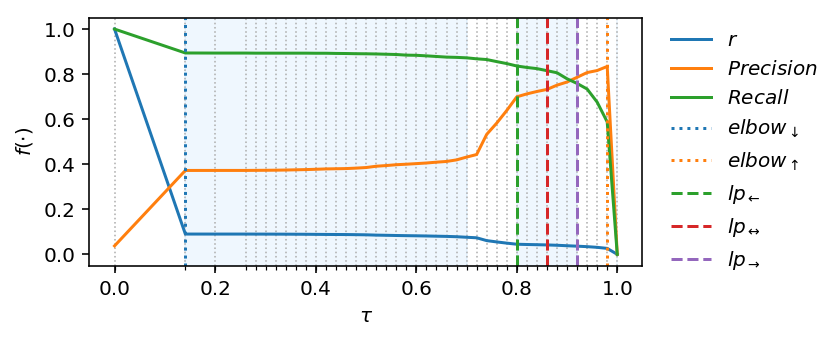

In [22]:
models = [m for m in get_model_files() if m.ad == 'binetv1' and m.id == 1 and m.model == 'paper']
for model in tqdm(models[:1]):
    e = Evaluator(model)
    binarizer = e.binarizer
    for axis in [2]:
        fig, r, rp, rpp = plot(e, attr_index=0, axis=axis)
        fig.tight_layout()
        fig.savefig(str(out_dir / 'heuristics.pdf'))